In [1]:
%matplotlib inline
import numpy as np

### Finesse Simulation portion
import pykat
import pylab as pl

kat_code = '''
l laser 1 0 nin                          % Laser P=1W f_offset=0Hz

#tem laser 0 0 1.0 0.0 
#tem laser 2 0 1.0 0.0

mod EOM1 9M 0 1 pm nin n0            % Phase modulator f_mod=9MHz, modulation index=0.00
s smod 1 n0 nmod1
mod EOM2 45M 0 1 pm nmod1 nmod2     % Phase modulator f_mod=45MHz, modulation index=0.00

maxtem 4

s s0 0 nmod2 n1
bs pickoff 0 1 0 45 n1 dump n2 n3   
s s1 0.1 n2 n4                           % Space 10cm length

m1 ITM 0.014 0 0 n4 n5                 
s scavity 3994.5 n5 n6                        % Space 1m length
m1 ETM 5u 0 0 n6 n7                  

cav xarm ITM n5 ETM n6

attr ITM Rc -1934
attr ETM Rc 2245

pd1 PDH 9M 0 n4                        % Photodetector with demodulation at 15MHz, demodulation phase 0
pd PDrefl n4
pd PDtran n7                      
pd PDcirc n6

xaxis ETM phi lin -5 5 1001
#x2axis ITM L lin 0 100u 100 
'''
### Find the gaussian beam parameter at the first optic
basekat = pykat.finesse.kat() 
basekat.parseCommands(kat_code)
basekat.undumpNodes() #undump thevacuum nodes to get the right quantum noise


kat=basekat.deepcopy() #copy kat code
kat.verbose = False
out = kat.run()

freq = (3e8/(4*np.pi*kat.scavity.L) * out.x)/1e6

                                              ..-
    PyKat 1.0.19          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [211]:
## Change the modulation depth, https://alog.ligo-wa.caltech.edu/aLOG/index.php?callRep=8867
kat1=basekat.deepcopy() #copy kat code
kat1.verbose = False
kat1.EOM1.midx.value = 0.1
kat1.EOM2.midx.value = 0.07
out1 = kat1.run()

In [212]:
## Change the optical absorption of the ITM
kat2=basekat.deepcopy() #copy kat code
kat2.verbose = False
kat2.ITM.L.value = 5e-6
kat2.ITM.T.value = 1 - kat2.ITM.L.value - kat2.ITM.R.value
out2 = kat2.run()

In [233]:
## Change the Modal content
kat3=basekat.deepcopy() #copy kat code
kat3.verbose = False
kat3.parseCommands('tem laser 0 0 0.70 0.0 ')
kat3.parseCommands('tem laser 1 0 0.15 0.0 ')
kat3.parseCommands('tem laser 2 0 0.15 0.0 ')
out3 = kat3.run()

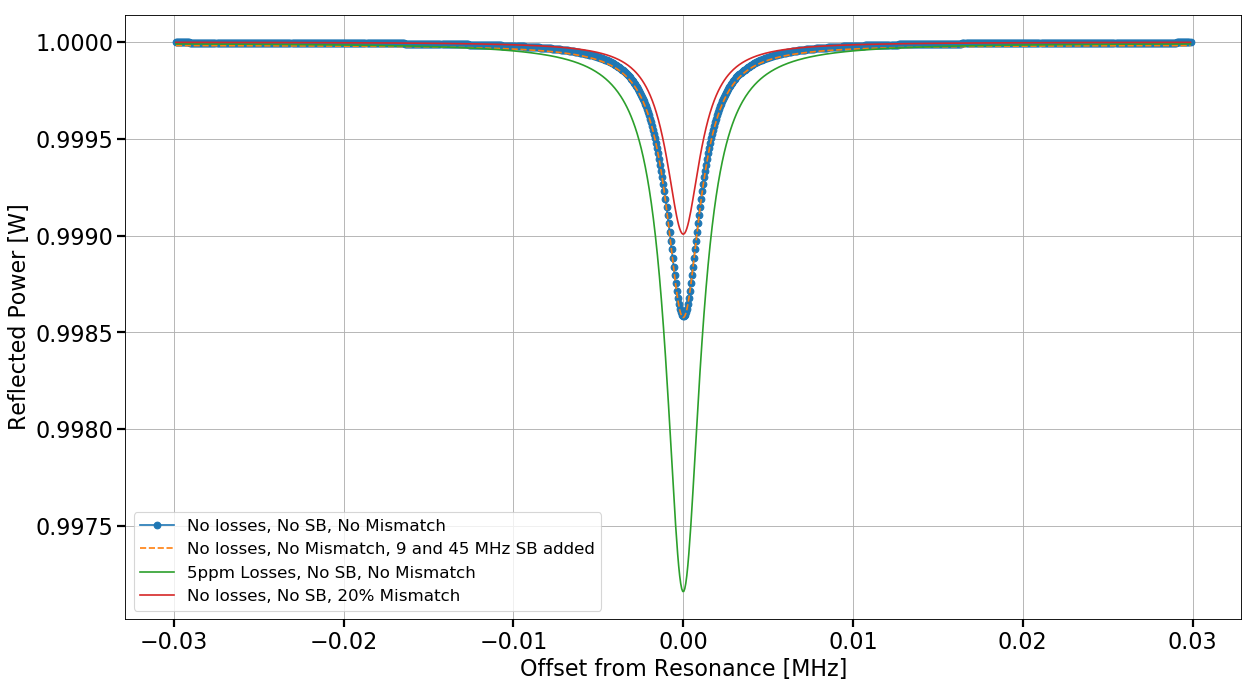

In [234]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)
pl.plot(freq, out['PDrefl'],'o-', label='No losses, No SB, No Mismatch')
pl.plot(freq, out1['PDrefl'], '--',label='No losses, No Mismatch, 9 and 45 MHz SB added' )
pl.plot(freq, out2['PDrefl'], label='5ppm Losses, No SB, No Mismatch')
pl.plot(freq, out3['PDrefl'], label='No losses, No SB, 30% Mismatch')
pl.legend(fontsize=15)

pl.xlabel("Offset from Resonance [MHz]",fontsize
          =20)
pl.ylabel("Reflected Power [W]",fontsize=20)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)

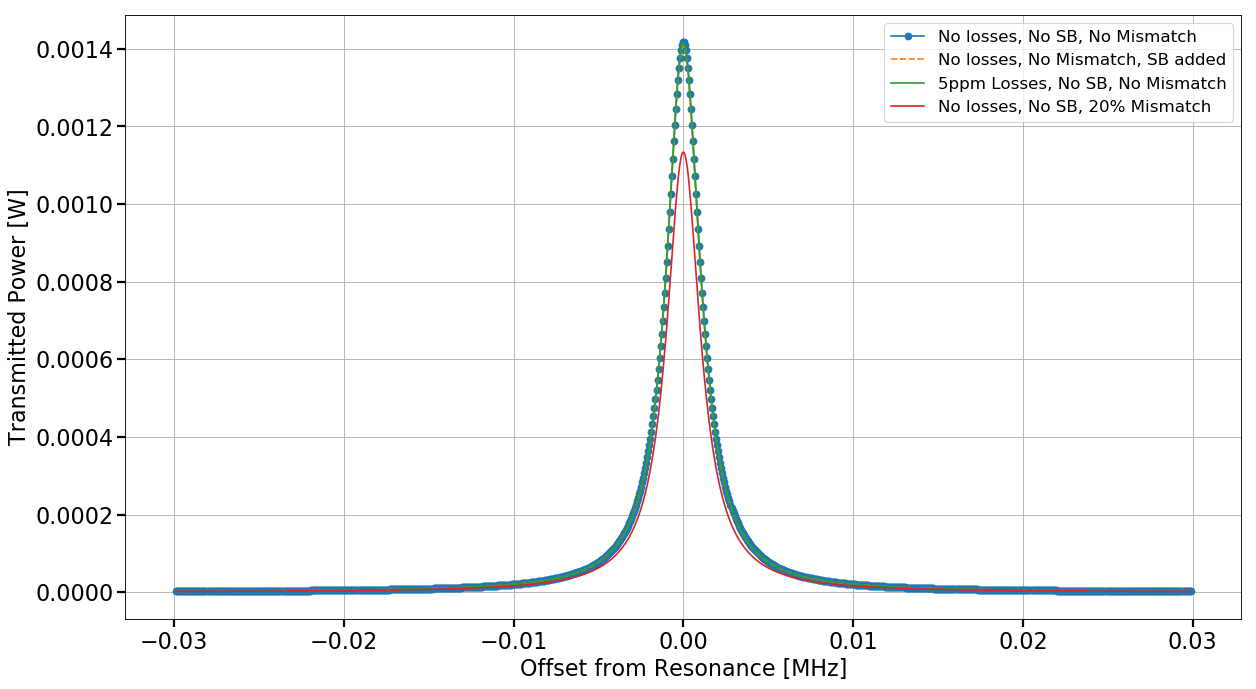

In [231]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)
pl.plot(freq, out['PDtran'],'o-', label='No losses, No SB, No Mismatch')
pl.plot(freq, out1['PDtran'], '--',label='No losses, No Mismatch, 9 and 45 MHz SB added' )
pl.plot(freq, out2['PDtran'], label='5ppm Losses, No SB, No Mismatch')
pl.plot(freq, out3['PDtran'], label='No losses, No SB, 30% Mismatch')
pl.legend(fontsize=15)

pl.xlabel("Offset from Resonance [MHz]",fontsize=20)
pl.ylabel("Transmitted Power [W]",fontsize=20)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)

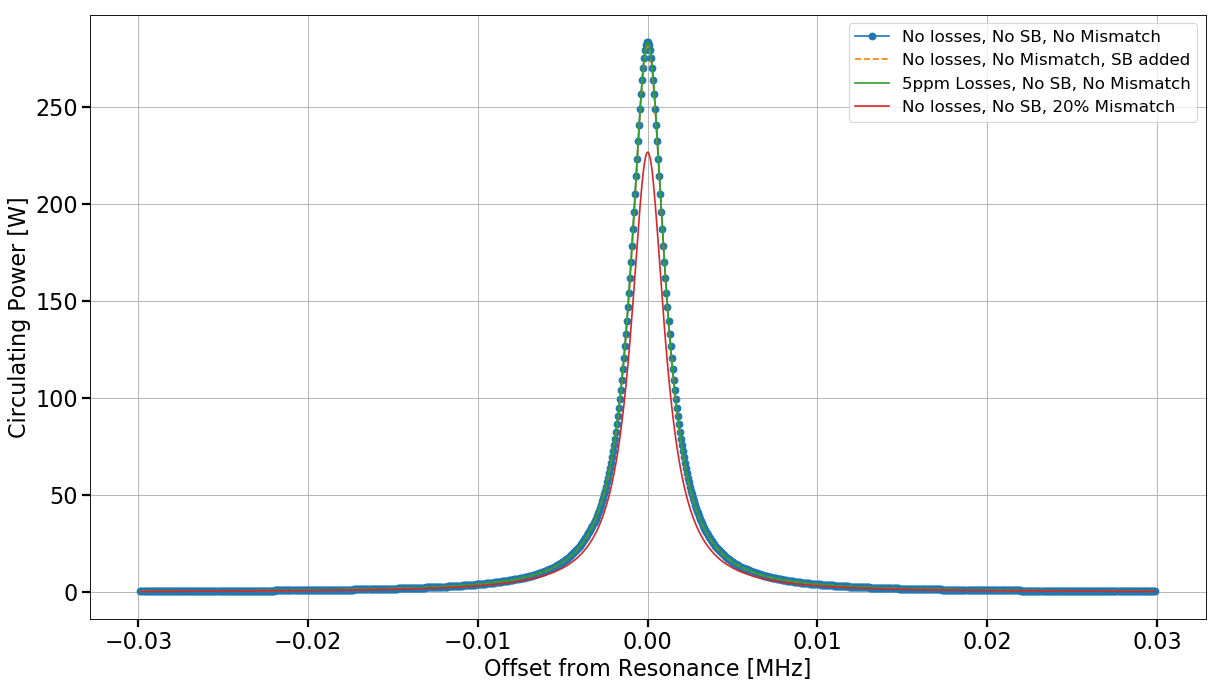

In [230]:
pl.figure(figsize=(18, 10), dpi=80)

pl.subplot(111)
pl.plot(freq, out['PDcirc'],'o-', label='No losses, No SB, No Mismatch')
pl.plot(freq, out1['PDcirc'], '--',label='No losses, No Mismatch, 9 and 45 MHz SB added' )
pl.plot(freq, out2['PDcirc'], label='5ppm Losses, No SB, No Mismatch')
pl.plot(freq, out3['PDcirc'], label='No losses, No SB, 30% Mismatch')
pl.legend(fontsize=15)

pl.xlabel("Offset from Resonance [MHz]",fontsize=20)
pl.ylabel("Circulating Power [W]",fontsize=20)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)

445.535289888


C:\Users\tvo88\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


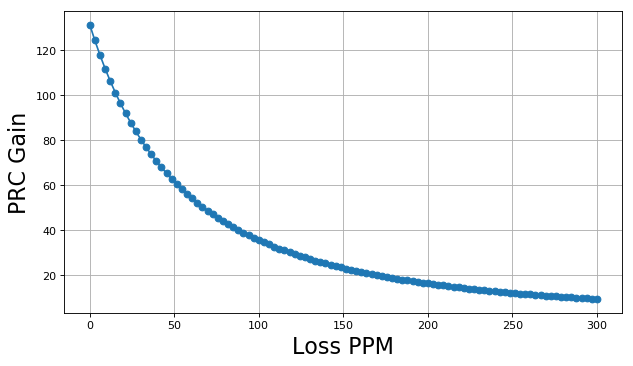

In [23]:
def PR_Gain(t_RM,r_RM,F,L):
    G = ( t_RM/ ( 1-r_RM*(1-F*L/np.pi) ) )**2
    return G

r1 = np.sqrt(1.0-3.6e-6)
r2 = np.sqrt(1.0-0.014)

t_RM = np.sqrt(0.03)
r_RM = np.sqrt(1 - t_RM**2)

F = np.pi * np.sqrt(r1*r2) /(1-r1*r2)
print(F)

L = np.linspace(0,300e-6,100)

G = PR_Gain(t_RM,r_RM,F,L)

pl.figure(figsize=(9, 5), dpi=80)
pl.subplot(111)
pl.plot(L*1e6, G ,'o-')

pl.legend(fontsize=15)

pl.xlabel("Loss PPM",fontsize=20)
pl.ylabel("PRC Gain",fontsize=20)

###Main plot formatting
pl.grid(True, zorder=-1)